# Credit Card Fraud Detection using Random Forest and Neural Networks

This notebook implements the credit card fraud detection system described in the repository's README. For a detailed problem statement and project overview, please refer to the README.

In this implementation, we'll build and compare two powerful machine learning approaches:
1. Random Forest Classifier with SMOTE balancing
2. Neural Network with regularization techni# Implementation Objective

To build and compare fraud detection classifiers using both Random Forest and Neural Network approaches. We'll evaluate their performance in identifying fraudulent transactions (label "1") from non-fraudulent ones (label "0)..rest. 




# Key Components of the Implementation

## Overview
In this project, we developed a comprehensive fraud detection system using two powerful machine learning approaches: Random Forest and Neural Network models. The implementation focuses on handling imbalanced credit card transaction data while providing robust model comparison and evaluation frameworks.

## Data Preprocessing Pipeline
- We'll separate features and target variables
- Apply StandardScaler to normalize features
- Implement stratified train-test split to maintain the rare class distribution


## Random Forest Model
- Implemented RandomForestClassifier with optimized hyperparameters:
- Applied SMOTE for balanced class training
- Incorporated feature importance analysis



## Neural Network Model
- Designed a Sequential model architecture:
- Implemented regularization techniques:
- Applied class weights for handling imbalanced data
- Used Early Stopping with 5-epoch patience


 ## Model Evaluation Framework
- Comprehensive evaluation metrics:
  - Classification reports
  - ROC curves and AUC scores
  - Precision-Recall curves
  - Confusion matrices
- Visual performance analysis:
  - Feature importance plots for Random Forest
  - Training history plots for Neural Network
  - Comparative ROC curves
  - Comparative Precision-Recall curves

 
- Implemented parallel processing in Random Forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
def load_and_preprocess_data(data):
    
    # Separate features and target
    X = df.drop('Class', axis=1)  # All columns except Class
    y = df['Class']               # Only the Class column
    
    return X, y

X, y = load_and_preprocess_data(df)

#information about the loaded data
print("Data shape:", X.shape)
print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

Data shape: (284807, 30)
Number of features: 30
Number of samples: 284807


In [5]:
# Create the preprocessing function
def preprocess_features(X):
    """Preprocess and scale the features"""
    # Separate time and amount for special scaling
    time = X['Time']
    amount = X['Amount']
    features = X.drop(['Time', 'Amount'], axis=1)
    
    # Create scalers
    scaler_features = StandardScaler()
    scaler_amount = StandardScaler()
    
    # Scale the features
    features_scaled = scaler_features.fit_transform(features)
    amount_scaled = scaler_amount.fit_transform(amount.values.reshape(-1, 1))
    
    # Normalize time between 0 and 1
    time_scaled = time.values.reshape(-1, 1) / time.max()
    
    # Combine all scaled features
    X_scaled = np.hstack((time_scaled, features_scaled, amount_scaled))
    
    return X_scaled

In [6]:
#split the data into training and testing sets
X_scaled = preprocess_features(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,           # Use 20% of data for testing
    random_state=42,         # For reproducibility
    stratify=y               # Maintain same ratio of fraud/non-fraud in both sets
)

# verify split
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


In [7]:

# Train Random Forest and get predictions
def train_random_forest(X_train, X_test, y_train, y_test):
    """Train and evaluate Random Forest model"""
    # First handle class imbalance using SMOTE
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Create and train Random Forest model
    print("Training Random Forest model...")
    rf_model = RandomForestClassifier(
        n_estimators=100,    # Number of trees
        max_depth=10,        # Maximum depth of each tree
        min_samples_split=10, # Minimum samples required to split
        min_samples_leaf=5,   # Minimum samples required at leaf node
        random_state=42,      # For reproducibility
        n_jobs=-1            # Use all available cores
    )
    
    # Fit the model
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    rf_y_pred = rf_model.predict(X_test)
    rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    return rf_model, rf_y_pred, rf_y_pred_proba


# Train model and get predictions
rf_model, rf_y_pred, rf_y_pred_proba = train_random_forest(X_train, X_test, y_train, y_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, rf_y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_y_pred_proba):.4f}")

Applying SMOTE to balance classes...
Training Random Forest model...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.85      0.57        98

    accuracy                           1.00     56962
   macro avg       0.71      0.92      0.78     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9805


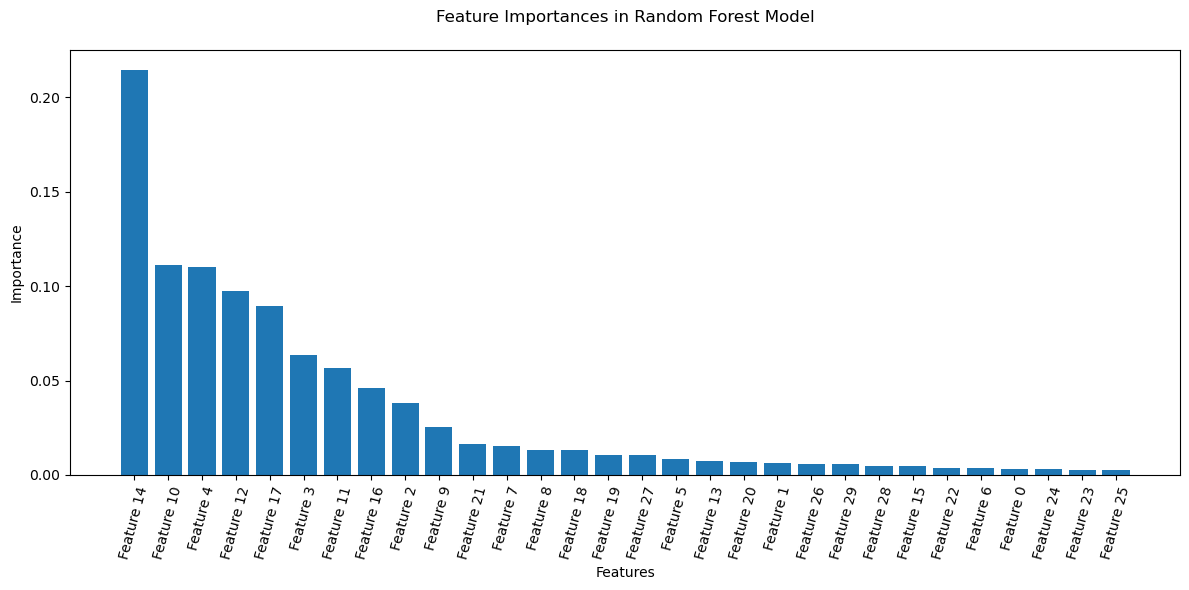

In [8]:
# Feature Importance Plot
def plot_feature_importance(model, X):
    """Plot feature importances of the random forest model"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances in Random Forest Model', pad=20)
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [f'Feature {i}' for i in indices], rotation=75)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()


plot_feature_importance(rf_model, X_test)


In [9]:
# Create the neural network model
def create_model(input_dim):
    model = Sequential([
        # Input layer
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [10]:
# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Create the model
model = create_model(X_train.shape[1])

# Calculate class weights for imbalanced dataset
n_samples = len(y_train)
n_positive = sum(y_train)
n_negative = n_samples - n_positive
class_weight = {
    0: (1 / n_negative) * (n_samples / 2),
    1: (1 / n_positive) * (n_samples / 2)
}

C:\Users\Antoun\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model
print("Training the neural network...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=1
)

Training the neural network...
Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7209 - loss: 0.4423 - val_accuracy: 0.9702 - val_loss: 0.1977
Epoch 2/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9321 - loss: 0.2609 - val_accuracy: 0.9737 - val_loss: 0.1487
Epoch 3/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9446 - loss: 0.1974 - val_accuracy: 0.9906 - val_loss: 0.0862
Epoch 4/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9639 - loss: 0.1636 - val_accuracy: 0.9870 - val_loss: 0.0869
Epoch 5/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9636 - loss: 0.1585 - val_accuracy: 0.9829 - val_loss: 0.0877
Epoch 6/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9642 - loss: 0.1188 - val_accuracy: 0.9899 - val_loss: 0.0743
Epoch 7/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9684 - loss: 0.1601 - val_accuracy: 0.9852 - val_loss: 0.0763
Epoch 8/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9647 - 

In [12]:
# Evaluate the model
print("\nEvaluating the model...")
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")




Evaluating the model...
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.90      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962


ROC-AUC Score: 0.9758


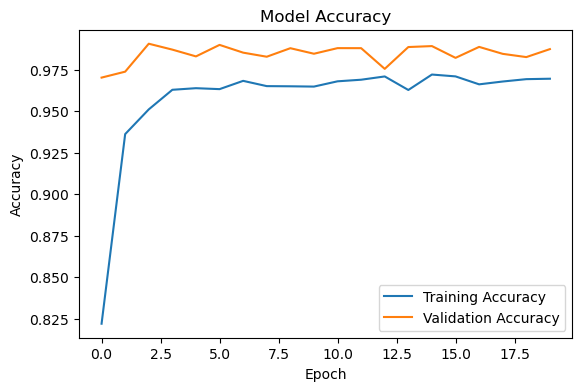

In [13]:
# Plot training history
plt.figure(figsize=(14, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step


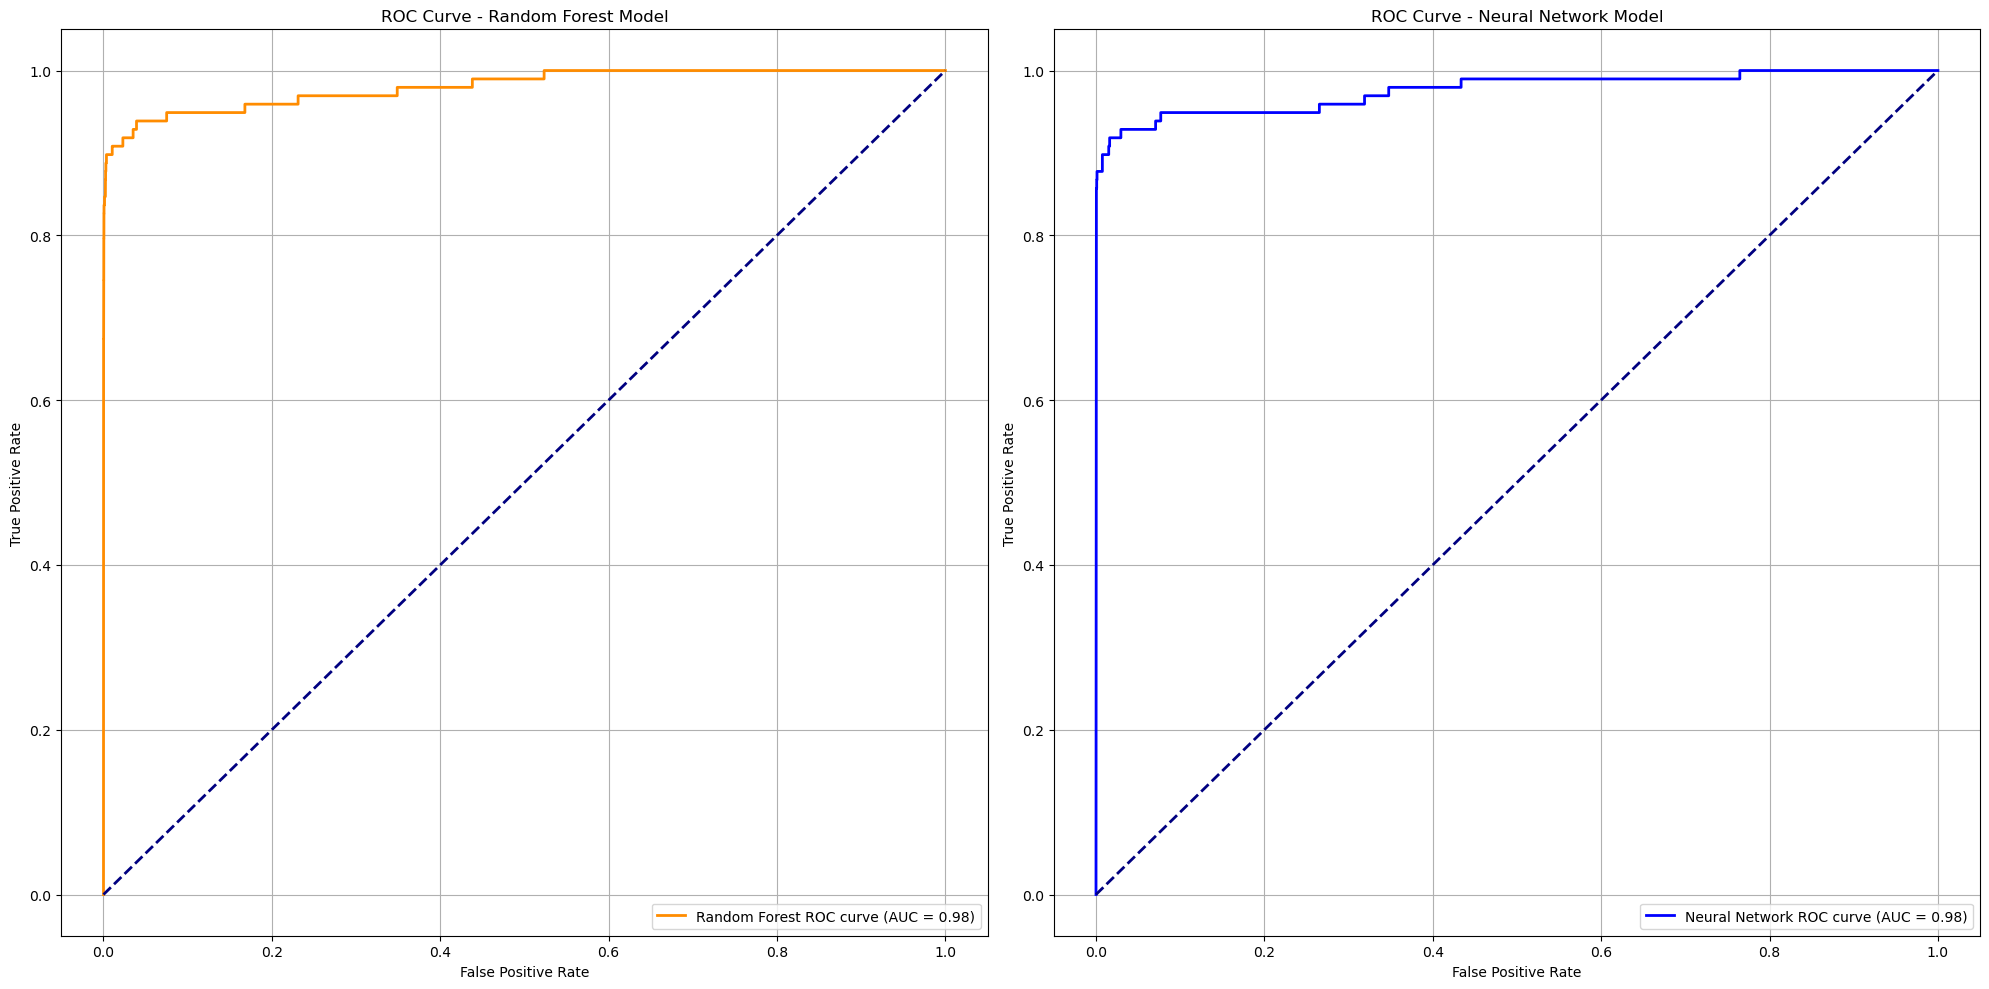


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.85      0.57        98

    accuracy                           1.00     56962
   macro avg       0.71      0.92      0.78     56962
weighted avg       1.00      1.00      1.00     56962


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.90      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962



In [14]:
plt.figure(figsize=(20, 10))

# Random Forest ROC Curve
plt.subplot(1, 2, 1)
# Use rf_model predictions
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, 
         label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)

# Neural Network ROC Curve
plt.subplot(1, 2, 2)
# Use neural network predictions
nn_pred_proba = model.predict(X_test)  # Get neural network probabilities
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2,
         label=f'Neural Network ROC curve (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network Model')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print classification reports for both models
print("\nRandom Forest Classification Report:")
rf_pred = (rf_pred_proba > 0.5).astype(int)
print(classification_report(y_test, rf_pred))

print("\nNeural Network Classification Report:")
nn_pred = (nn_pred_proba > 0.5).astype(int)
print(classification_report(y_test, nn_pred))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step


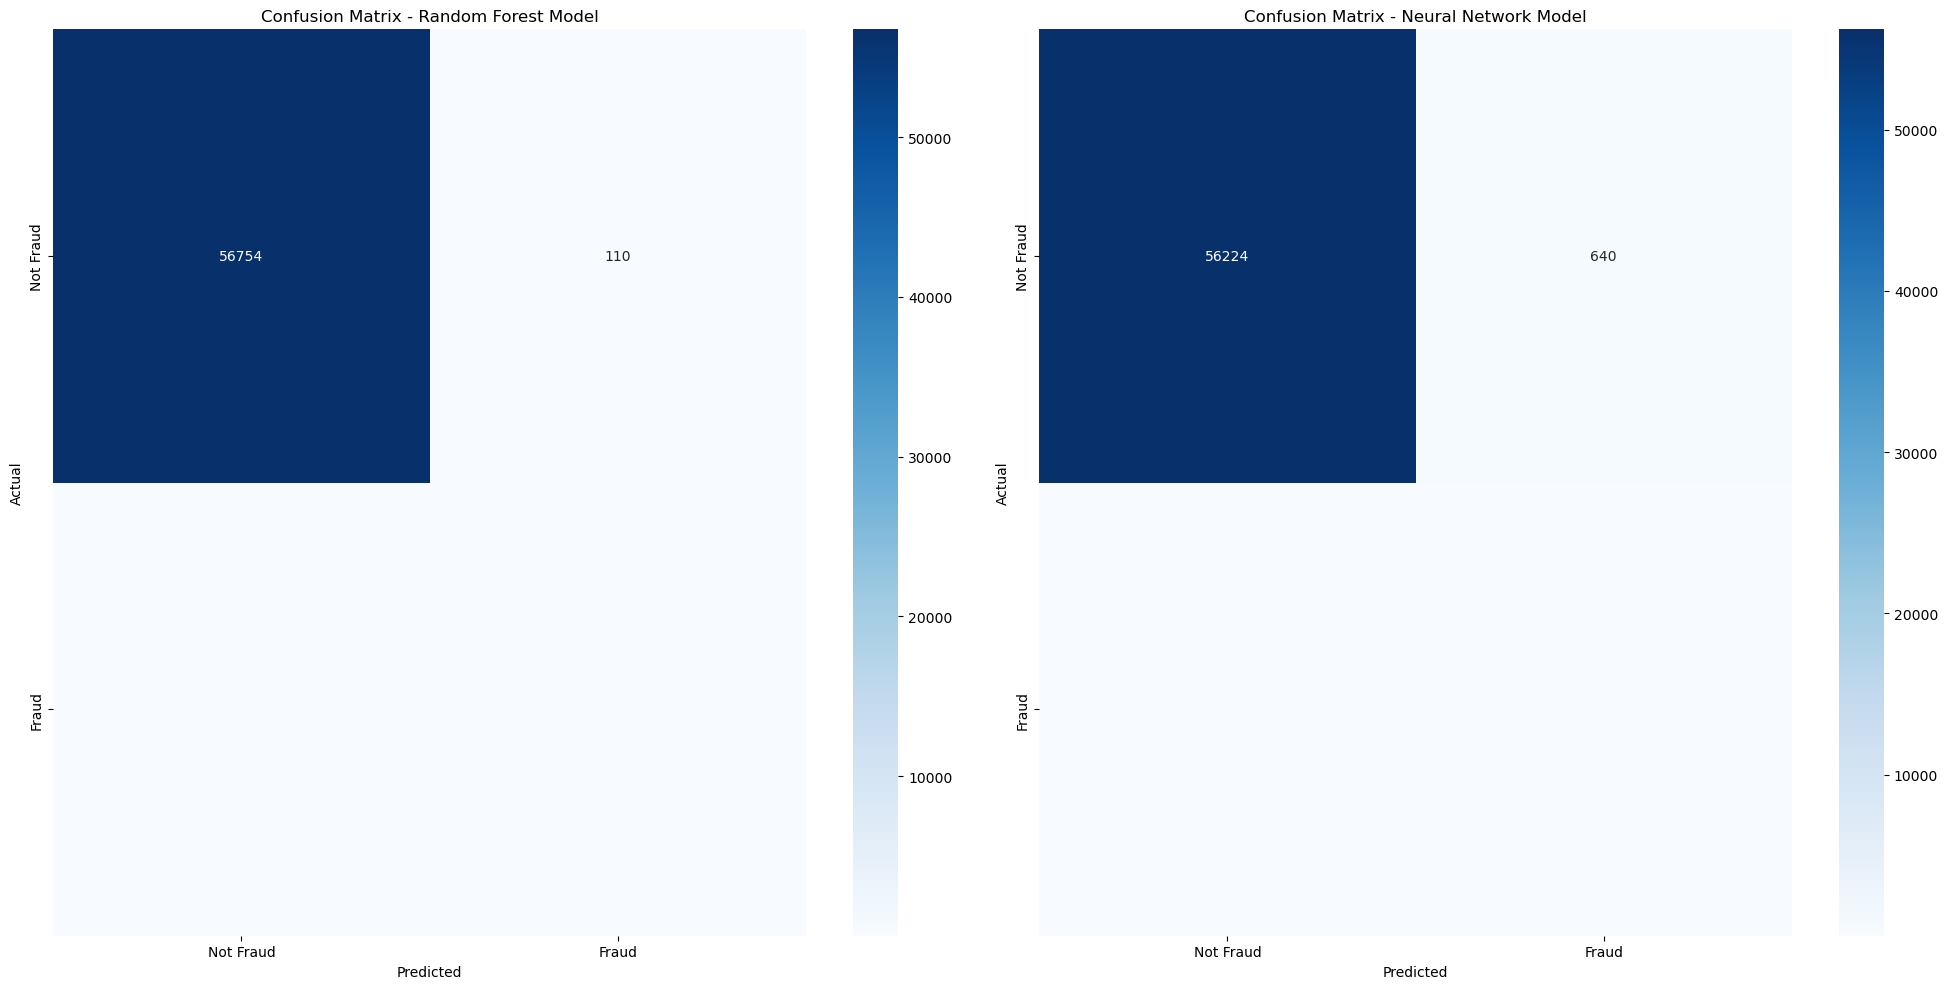

In [25]:
# Predictions for Random Forest
rf_pred = (rf_model.predict_proba(X_test)[:, 1] > 0.5).astype(int)

# Predictions for Neural Network
nn_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)

# Confusion Matrix for Neural Network
cm_nn = confusion_matrix(y_test, nn_pred)

# Plotting
plt.figure(figsize=(20, 10))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix - Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Neural Network Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix - Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


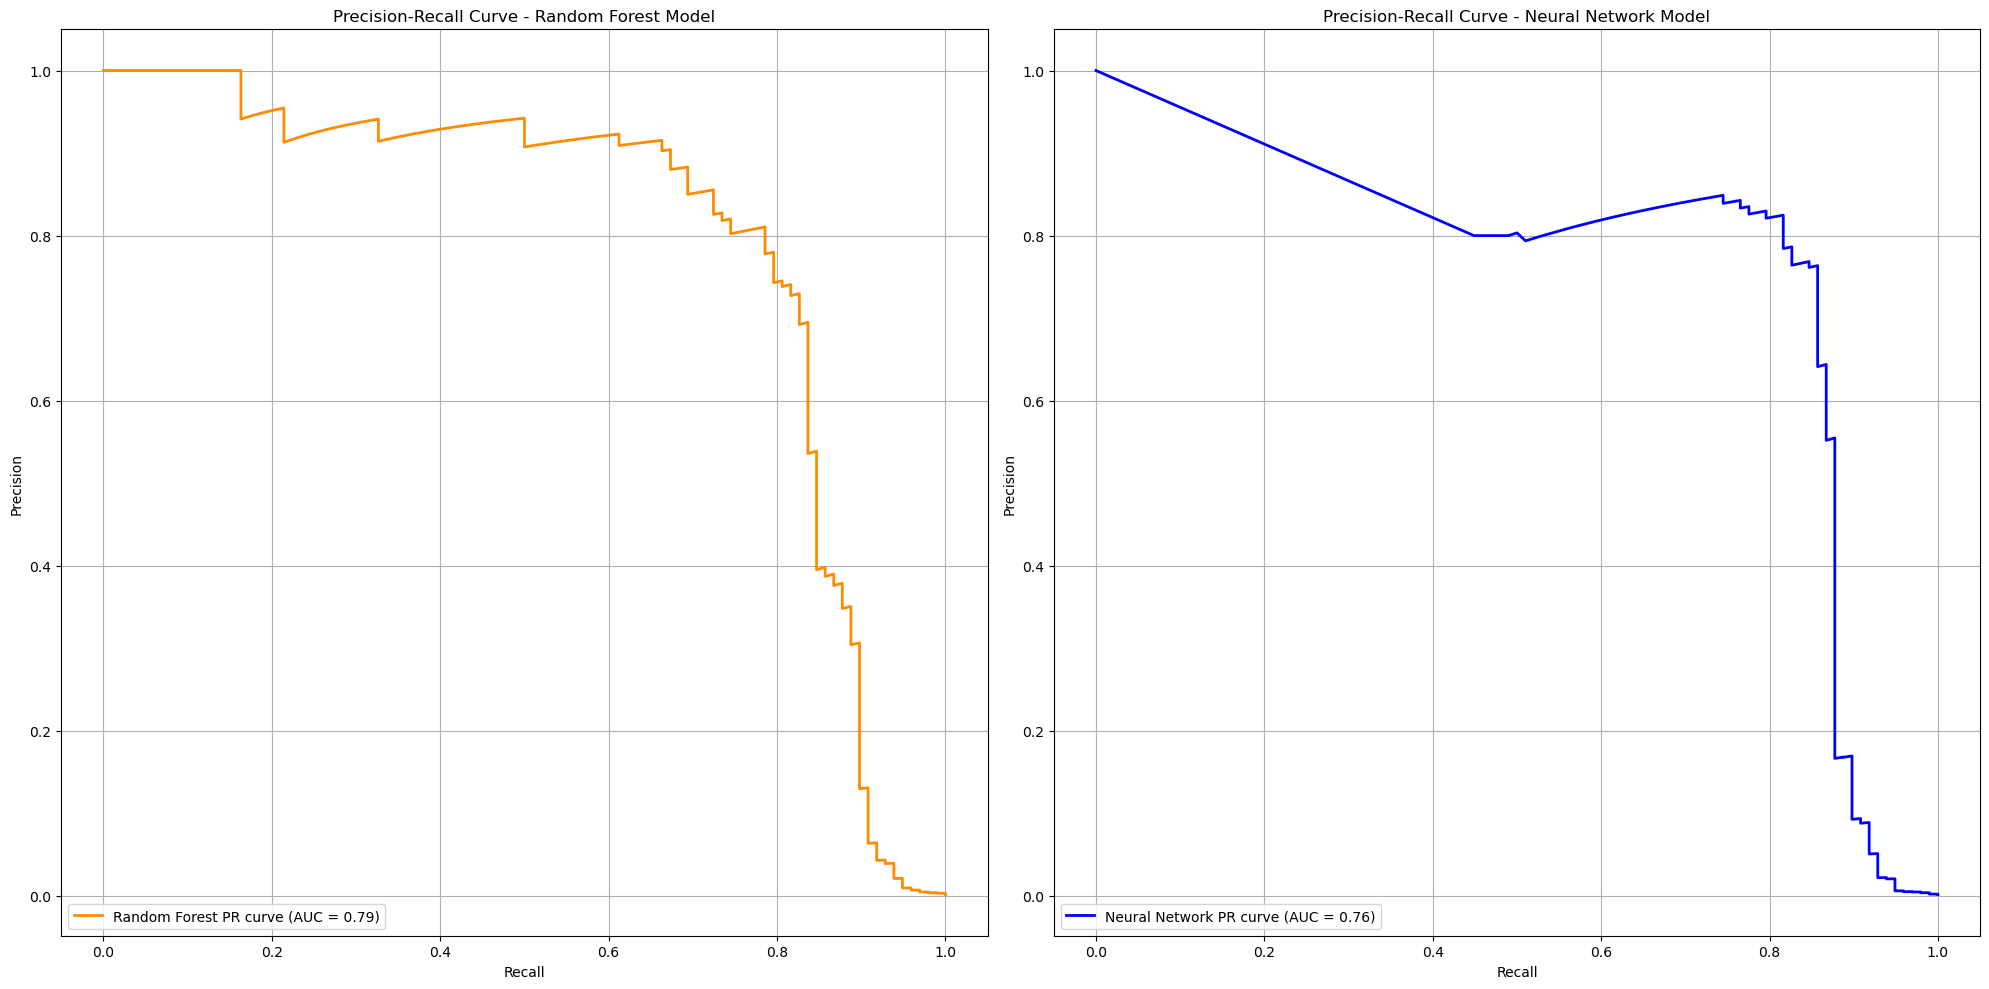

In [21]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_test, y_pred_proba):
    """Plot precision-recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve', pad=20)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
# Precision-Recall for Random Forest
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
pr_auc_rf = auc(recall_rf, precision_rf)

# Precision-Recall for Neural Network
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, model.predict(X_test))
pr_auc_nn = auc(recall_nn, precision_nn)

# Plotting
plt.figure(figsize=(20, 10))

# Random Forest Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_rf, precision_rf, color='darkorange', lw=2, 
         label=f'Random Forest PR curve (AUC = {pr_auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Model')
plt.legend(loc='lower left')
plt.grid(True)

# Neural Network Precision-Recall Curve 
plt.subplot(1, 2, 2)
plt.plot(recall_nn, precision_nn, color='blue', lw=2,
         label=f'Neural Network PR curve (AUC = {pr_auc_nn:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network Model')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Key Observations

The Random Forest model has a slightly higher ROC-AUC score (0.9805) compared to Neural Network (0.9758). However, the models show different strengths:

- Random Forest excels in precision (0.43 for fraud class), meaning it's more reliable when it predicts fraud
- Neural Network achieves better recall (0.90 for fraud class), indicating it catches more actual fraud cases

The choice between models depends on the specific use case:
- Use Random Forest if minimizing false positives is crucial
- Use Neural Network if capturing more potential fraud cases is priority

# Potential Improvements

- Implement cross-validation for more robust evaluation
- Experiment with hyperparameter tuning, especially for Neural Network
- Try ensemble methods combining both models' strengths
- Explore more advanced neural architectures
- Consider cost-sensitive le
  arning approaches